# Proyecto del curso de Computación Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>




### Librerias a usar

In [2]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

### Define el objeto Item en el problema
Un objeto de clase Item almacena el valor del item y el area del item 

In [3]:
class Item(object):
    def __init__(self, area):
        self.area  = area  # Area que ocupa el item en un bin.

### Define el objeto Bin en el problema
Un objeto de clase Bin almacena el valor del bin y el area disponible

In [4]:
class Bin(object):
    def __init__(self, area):
        self.area  = area  # Area disponible en el bin

### Define la estructura de un individuo en el AG con sus operadores genéticos 

Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de NUM_ITEMS elementos (genes),
cada gen i puede asumir N posibles alelos: Donde N es la cantidad de Bins en total.


In [42]:
class Individual:
    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 

    def mutation_flip(self):
        "Cambia aleatoriamente el alelo de un gen."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            new_chromosome[mutGene] = 1
        else:
            new_chromosome[mutGene] = 0
        return Individual(new_chromosome)
    
    def mutation_inversion(self):
        """
        Invierte el orden de todos los genes comprendidos entre 2 puntos 
        seleccionados al azar en el cromosoma
        """
        new_chromosome = deepcopy(self.chromosome)
        p1 = random.randrange(0,len(new_chromosome))
        p2 = p1
        while p2 == p1:
            p2 = random.randrange(0,len(new_chromosome))
        if p2 > p1:
            new_chromosome[p1:p2] = new_chromosome[p1:p2][::-1]
        else:
            new_chromosome[p2:p1] = new_chromosome[p2:p1][::-1]
        return Individual(new_chromosome)
    
    def mutation_uniform(self):
        """
        Genera una mutación uniforme en todo dado un valor aleatorio de probabilidad
        """
        new_chromosome = deepcopy(self.chromosome)
        prob = random.random()
        new_chromosome = [random.randint(0,len(BinPool)) if random.uniform(0, 1)<prob else a for a in new_chromosome]
        return Individual(new_chromosome)

### Funcion para obtener el fitness de un cromosoma

In [43]:
def get_fitness(chromosome, items,bins):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los items incluidos en el cromosoma
       Si el peso total es mayor que max_weight -> el fitness es 0"""
    fitness = 0 # initialize fitness to 0
    sum_weight = [0]*len(bins)
    for i in range(len(items)):
        if chromosome[i]:
            try:
                sum_weight[chromosome[i]-1] += items[i].area
                fitness += items[i].area
            except:
                print(chromosome[i],len(sum_weight))
                assert False
    for i,bin_weight in enumerate(sum_weight):
        if bins[i].area < bin_weight:
            return 0
    return fitness

### Funcion para evaluar una población de individuos 

In [44]:
def evaluate_population(population, items, bins):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome, items,bins)                                   

### Funcion para inicializar aleatoriamente una población de individuos

In [45]:
def init_population(popsize, chromosome_size,size_bins, zeroes=False):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       Si zeroes==False La inicializacion es aleatoria (por defecto), si zeroes=True los cromosomas son vectores de ceros"""
    population = []
    for i in range(popsize):
        if zeroes:
            new_chromosome = [0 for j in range(chromosome_size)]  # vector de zeros de tamaño chromosome_size
        else:
            new_chromosome = [random.randint(0,size_bins) for j in range(chromosome_size)]  #vector aleatorio de 0s y 1s de tamaño chromosome_size
        
        population.append( Individual(new_chromosome) )
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [46]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    iParent1 = random.randint(0,popsize-1)
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    iParent2 = random.randint(0,popsize-1)
    while iParent2 == iParent1:
        iParent2 = random.randint(0,popsize-1)
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [47]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

### Operadores de Seleccion de sobrevivientes


#### Función de selección de la poblacion para la sgte generación por ranking
Selecciona la población siguiente ranqueando los individuos de la poblacion actual (population) y la poblacion descendencia (offspring_population) y escogiendo los mejores numsurvivors  individuos 

In [48]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

### Algoritmo Genetico para encontrar soluciones al problema
Recibe una poblacion inicial, lista de items,lista de bins, numero de generaciones (ngen), taza de mutación (pmut), operador de cruzamiento (crossover), operador de mutacion (mutation), metodo de seleccion de padres (selection_parents_method), metodo de seleccion de sobrevivientes (selection_survivors_method) 

In [49]:
def genetic_algorithm(population, items, bins, ngen=100, pmut=0.1, 
                      crossover="onepoint", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para el problema de la mochila
        items:      pool de items a escoger para la mochila. 
                    Debe ser una lista de objetos de clase Item
        max_weight: maximo peso que puede soportar la mochila
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    
    popsize = len(population)
    evaluate_population(population, items, bins)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                elif mutation == "inversion":
                    offspring_population[i] = offspring_population[i].mutation_inversion() # invierte todos los genes entre 2 puntos al azar
                elif mutation == "uniform":
                    offspring_population[i] = offspring_population[i].mutation_uniform() # invierte todos los genes entre 2 puntos al azar
                else:
                    raise NotImplementedError   
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, items, bins)   # evalua la poblacion descendencia
        
        ## Selecciona individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError
            
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))
        
    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

 ## Probando el Algoritmo genetico

<b>Define el pool de items a colocar y bins disppnivles </b>

In [94]:
NUM_ITEMS = 10        # numero de items
NUM_BINS = 5        # numero de items
MAX_ITEM_AREA = 30  # maximo peso posible de cada  item
MAX_BIN_AREA = 50   # maximo valor posible de cada  item
#pool de items generado aleatoriamente
ItemPool = [ Item(random.randint(0,MAX_ITEM_AREA)) for x in range (0,NUM_ITEMS)]
BinPool = [ Bin(random.randint(0,MAX_BIN_AREA)) for x in range (0,NUM_BINS)]

<b> Ejecuta el algoritmo genetico </b>

In [95]:
## Hiperparametros del algoritmo genetico
POPSIZE = 100       # numero de individuos
GENERATIONS = 1000   # numero de generaciones
PMUT = 0.9       # taza de mutacion

## Inicializa una poblacion inicial de forma aleatoria
population = init_population(POPSIZE, NUM_ITEMS,len(BinPool))

In [96]:
# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness = genetic_algorithm(population, ItemPool, BinPool, GENERATIONS, PMUT, 
                                          crossover="uniform", mutation="uniform", 
                                          selection_parents_method = 'roulette', 
                                          selection_survivors_method = 'ranking')

Poblacion inicial, best_fitness = 0
generacion 0, (Mejor fitness = 0)
generacion 10, (Mejor fitness = 129)
generacion 20, (Mejor fitness = 129)
generacion 30, (Mejor fitness = 129)
generacion 40, (Mejor fitness = 131)
generacion 50, (Mejor fitness = 136)
generacion 60, (Mejor fitness = 136)
generacion 70, (Mejor fitness = 136)
generacion 80, (Mejor fitness = 136)
generacion 90, (Mejor fitness = 136)
generacion 100, (Mejor fitness = 136)
generacion 110, (Mejor fitness = 136)
generacion 120, (Mejor fitness = 136)
generacion 130, (Mejor fitness = 136)
generacion 140, (Mejor fitness = 136)
generacion 150, (Mejor fitness = 136)
generacion 160, (Mejor fitness = 136)
generacion 170, (Mejor fitness = 136)
generacion 180, (Mejor fitness = 136)
generacion 190, (Mejor fitness = 136)
generacion 200, (Mejor fitness = 136)
generacion 210, (Mejor fitness = 138)
generacion 220, (Mejor fitness = 138)
generacion 230, (Mejor fitness = 138)
generacion 240, (Mejor fitness = 138)
generacion 250, (Mejor fitn

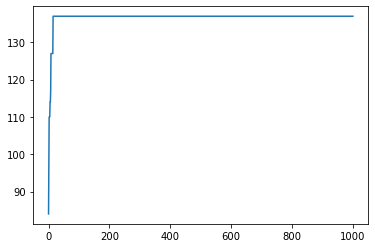

In [90]:
plt.plot(bestfitness)
plt.show()